## Libraries

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
from itertools import combinations
import seaborn as sns
from scipy.stats import f_oneway
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist
import umap.umap_ as umap

ModuleNotFoundError: No module named 'umap.umap_'

## Dataset - company aspects by firm

In [3]:
df = pd.read_csv("C:/Users/lasko/Documents/Bocconi/2nd_Semester/Natural Language Processing/Final Project/Final_company_aspect_matrix_with_counts.csv")
len(df)

4618

In [4]:
df.head()

,firm,aspect,avg_star_rating,n_mentions
0,AFH Wealth Management,culture,2.769231,13
1,AFH Wealth Management,growth & learning,3.444444,9
2,AFH Wealth Management,hr & recruitment,2.521739,23
3,AFH Wealth Management,job role clarity,1.000000,4
4,AFH Wealth Management,job security,1.400000,5


## EDA for company aspects

In [6]:
df['n_mentions'].min(), df['n_mentions'].max()

(1, 1237)

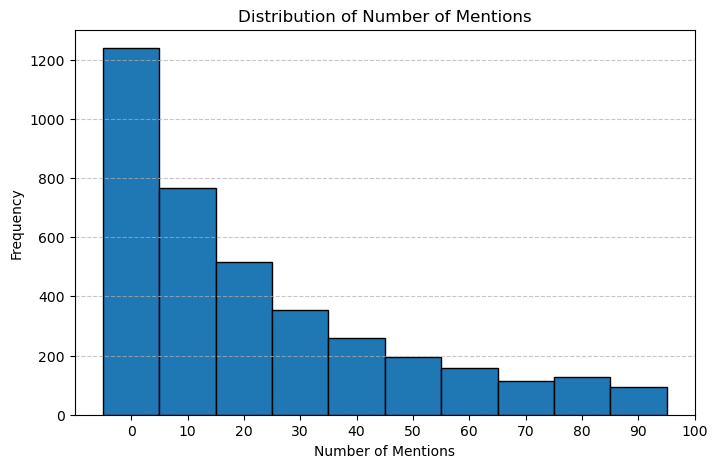

In [7]:
bins = list(range(0, 110, 10))

plt.figure(figsize=(8,5))
plt.hist(df['n_mentions'], bins=bins, edgecolor='black', align='left')
plt.title('Distribution of Number of Mentions')
plt.xlabel('Number of Mentions')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The distribution of the number of times an aspect has been mentioned for a specific company is **highly left-skewed**. 

In [8]:
companies_count = len(df.groupby('firm'))
print(f'Currently the dataset consists of {companies_count} companies')

Currently the dataset consists of 295 companies


In [9]:
mentions_count = df.groupby('firm')['n_mentions'].sum()
mentions_count = mentions_count.sort_values(ascending=False)

Top 20 companies by total number of aspect mentions:

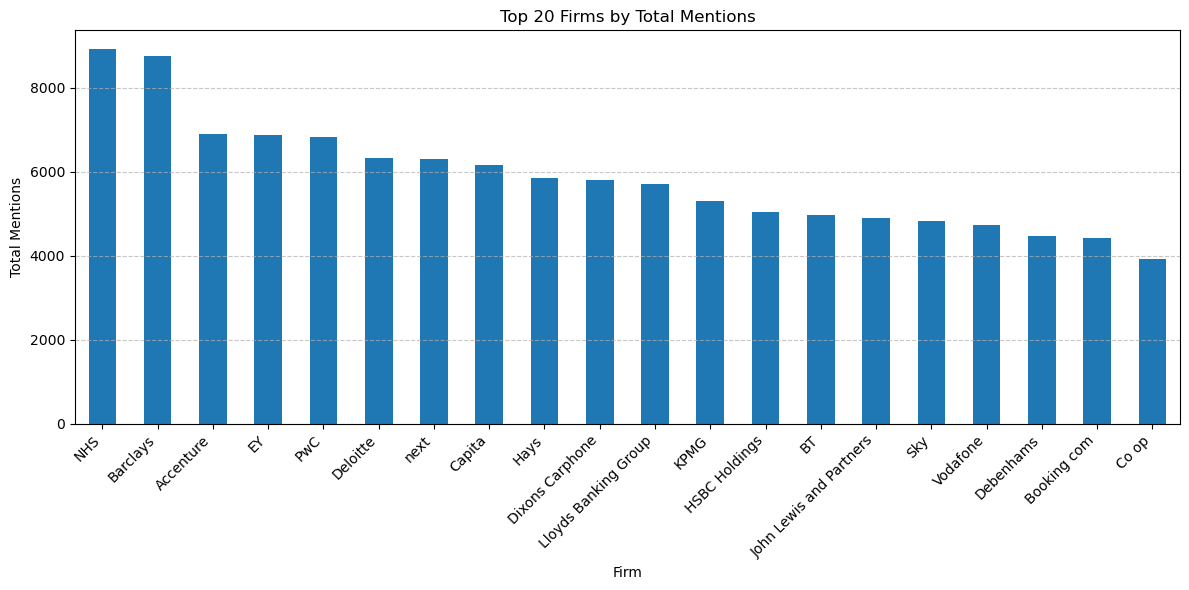

In [10]:
mentions_count.head(20).plot(kind='bar', figsize=(12, 6))
plt.title("Top 20 Firms by Total Mentions")
plt.xlabel("Firm")
plt.ylabel("Total Mentions")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


There are **17 unique aspects** in the dataset.

In [11]:
len(df.groupby('aspect'))

17

Total number of mentions per aspect:

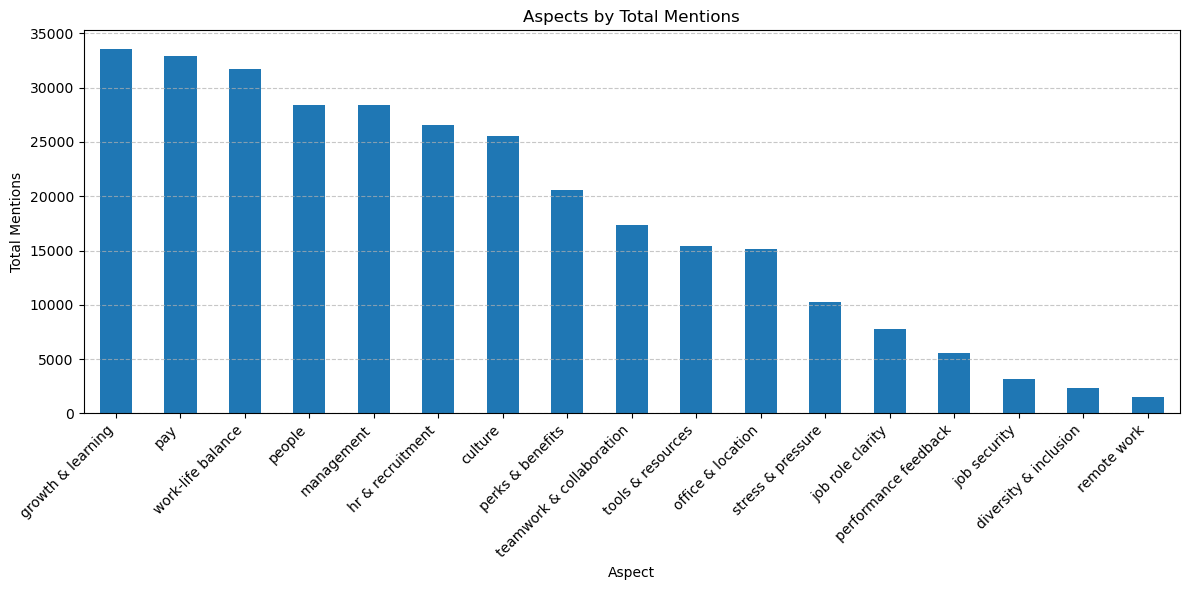

In [12]:
aspect_mentions = df.groupby('aspect')['n_mentions'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
aspect_mentions.plot(kind='bar')
plt.title(f"Aspects by Total Mentions")
plt.xlabel("Aspect")
plt.ylabel("Total Mentions")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The **TOP 5 most commonly mentioned aspects** are:
- growth & learning
- pay
- work-life balance
- people
- management

The **TOP 5 most rarely mentioned aspects** are:
- remote work
- diversity & inclusion
- job security
- performance feedback
- job role clarity

In [13]:
# Count number of aspects per firm
aspect_count = df.groupby('firm')['aspect'].count().reset_index(name='n_aspects')
aspect_count.sort_values('n_aspects', ascending=False)

,firm,n_aspects
147,J P Morgan,17
165,Leaders Romans Group,17
150,JP Boden and Co,17
151,Jaguar Land Rover,17
153,John Lewis and Partners,17
...,...,...
292,i Net Solution,4
198,Office of Rail Regulation,3
135,Health Protection Agency,1
270,UKCIL,1


In [14]:
aspect_count[aspect_count['n_aspects']<5]

,firm,n_aspects
135,Health Protection Agency,1
198,Office of Rail Regulation,3
252,Tengizchevroil,1
270,UKCIL,1
292,i Net Solution,4


In [15]:
len(aspect_count[aspect_count['n_aspects']<5])

5

There are 5 companies for which the number of detected, different aspects is below 5.

In [16]:
# number of companies having >= 10 aspects:
firms_10 = aspect_count[aspect_count['n_aspects'] >= 10]
len(firms_10)

280

There are 280 companies (out of 295) having more than 10 different aspects detected.

In [17]:
# number of total reviews for those companies:
list_of_companies = list(firms_10['firm'])
print('Those companies are:')
print(list_of_companies)

Those companies are:
['AFH Wealth Management', 'AJ Bell', 'ASOS', 'AXA UK', 'Abcam', 'Accenture', 'Accor', 'Achieving for Children', 'ActionCOACH', 'Active Care Group', 'Adecco', 'Age UK The National Charity', 'AlixPartners', 'American Express', 'Amey', 'Angard Staffing', 'Anglian Water', 'Anglo American', 'Animal and Plant Health Agency', 'Aon', 'Apple', 'Arcadia', 'Arnold Clark', 'AstraZeneca', 'Aviva', 'BAT', 'BBC', 'BDO', 'BHS', 'BIS', 'BNP Paribas', 'BNY Mellon', 'BPP Holdings', 'BT', 'Babcock International Group', 'Babylon Health', 'Bain and Company', 'Balfour Beatty', 'Bannatyne Group', 'Barchester Healthcare', 'Barclays', 'Barnardo s', 'Barnet and Chase Farm Hospitals NHS Trust', 'Barnett Waddingham', 'Barratt Developments', 'Barts Health NHS Trust', 'Bayer', 'Bloomberg L P', 'Blue Arrow', 'Blue Yonder', 'Booking com', 'Boston Consulting Group', 'Brewin Dolphin', 'British Red Cross', 'Brook Street', 'Bullhorn', 'Bupa', 'CBRE', 'Cambridge Assessment', 'Capita', 'Capital Group', 

## Clustering

Preparing necessary columns

In [27]:
df = pd.read_csv("C:/Users/lasko/Documents/Bocconi/2nd_Semester/Natural Language Processing/Final Project/Final_company_aspect_matrix_with_counts.csv")

In [28]:
# Create sentiment weighted score to cluster companies
df["sentiment_weighted"] = df["avg_star_rating"] * df["n_mentions"]

# total reviews each firm received (across all aspects)
firm_totals = df.groupby("firm")["n_mentions"].sum()

# proportion of all mentions that are for this aspect
df["share"] = df["n_mentions"] / df["firm"].map(firm_totals)

# combine with sentiment to normalize:
df["sentiment_share"] = df["avg_star_rating"] * df["share"]

# Build the full matrix of aspect scoring ("sentiment share") per firm
matrix  = df.pivot_table(index="firm", columns="aspect", values="sentiment_share").fillna(0)

In [29]:
df.head()

,firm,aspect,avg_star_rating,n_mentions,sentiment_weighted,share,sentiment_share
0,AFH Wealth Management,culture,2.769231,13,36.0,0.076923,0.213018
1,AFH Wealth Management,growth & learning,3.444444,9,31.0,0.053254,0.183432
2,AFH Wealth Management,hr & recruitment,2.521739,23,58.0,0.136095,0.343195
3,AFH Wealth Management,job role clarity,1.000000,4,4.0,0.023669,0.023669
4,AFH Wealth Management,job security,1.400000,5,7.0,0.029586,0.041420


In [30]:
matrix.head()

aspect,culture,diversity & inclusion,growth & learning,hr & recruitment,job role clarity,job security,management,office & location,pay,people,performance feedback,perks & benefits,remote work,stress & pressure,teamwork & collaboration,tools & resources,work-life balance
firm,,,,,,,,,,,,,,,,,
AFH Wealth Management,0.213018,0.000000,0.183432,0.343195,0.023669,0.041420,0.337278,0.130178,0.213018,0.331361,0.029586,0.142012,0.000000,0.035503,0.213018,0.112426,0.224852
AJ Bell,0.287719,0.010526,0.387719,0.336842,0.029825,0.024561,0.201754,0.285965,0.268421,0.343860,0.040351,0.256140,0.022807,0.071930,0.178947,0.173684,0.156140
ASOS,0.301859,0.019322,0.258476,0.212906,0.048852,0.017864,0.143274,0.243164,0.170252,0.317536,0.027707,0.482319,0.005468,0.086766,0.148742,0.123223,0.216916
AXA UK,0.282517,0.071329,0.434965,0.254545,0.086713,0.020979,0.248951,0.149650,0.283916,0.367832,0.039161,0.353846,0.034965,0.025175,0.191608,0.265734,0.271329
Abcam,0.512195,0.023035,0.555556,0.176152,0.066396,0.013550,0.234417,0.340108,0.140921,0.468835,0.046070,0.201897,0.025745,0.177507,0.211382,0.186992,0.258808


In [31]:
print(matrix.shape)

(295, 17)


Performing K-Means and Silhouette Score to find optimal number of clusters

In [32]:
# Scale the matrix
scaler = StandardScaler()
X = scaler.fit_transform(matrix)

# Search over a range of k and record silhouette
silhouette_scores = {}
for k in range(2, 11):        
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores[k] = silhouette_score(X, labels)

# Convert to a DataFrame
sil_df = (pd.DataFrame(list(silhouette_scores.items()), columns=["k", "silhouette"]).sort_values("k").reset_index(drop=True))

# Visualise
plt.figure(figsize=(6, 4))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores vs k")
plt.tight_layout()
plt.show()

# Optional – fit the *best* model and attach labels to the original matrix
# best_k = sil_df.loc[sil_df["silhouette"].idxmax(), "k"]
# best_kmeans = KMeans(n_clusters=int(best_k), n_init=10, random_state=42)
# matrix["cluster"] = best_kmeans.fit_predict(X)

# Save or inspect `matrix` if you want:
# matrix.to_csv("/mnt/data/company_clusters.csv")

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
sil_df.head()

,k,silhouette
0,2,0.099976
1,3,0.107073
2,4,0.095217
3,5,0.102053
4,6,0.060512


Inspecting this result: why is only 2 clusters the optimal number?

In [24]:
kmeans2 = KMeans(n_clusters=2, n_init=30, random_state=0).fit(X)
labels, counts = np.unique(kmeans2.labels_, return_counts=True)
print(dict(zip(labels, counts)))

outlier_idx = np.where(kmeans2.labels_ == 1)[0][0]
outlier_firm = matrix.index[outlier_idx]
print("Outlier firm:", outlier_firm)

# Quick look at its profile
display(matrix.loc[outlier_firm].sort_values(ascending=False).head())

AttributeError: 'NoneType' object has no attribute 'split'

<span style="color: red;"> Outlier detected! Ryan LLC has only two aspects detected with star rating equal to 5 and number of mentions equal to 1.</span>

Solution: filter dataframe for n_mentions >= threshold

In [ ]:
MIN_MENTIONS = 10 #Threshold

firm_totals = df.groupby("firm")["n_mentions"].transform("sum")
mask = firm_totals >= MIN_MENTIONS
df_filtered = df[mask].copy()

print(f"Dropped {len(df) - len(df_filtered)} firms "
      f"(< {MIN_MENTIONS} mentions); {df_filtered['firm'].nunique()} remain.")

Dropped 22 firms (< 10 mentions); 325 remain.


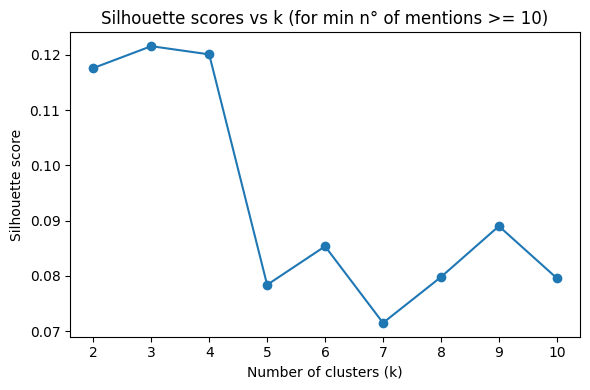

Silhouette scores: {2: 0.1176164913934094, 3: 0.12157274595731817, 4: 0.12008601367244177, 5: 0.07838800483297628, 6: 0.08535558816672838, 7: 0.07150061572081717, 8: 0.07979553765258843, 9: 0.08900828447214462, 10: 0.0795932888877011}
Best k = 3


In [ ]:
# K-MEANS on filtered df
firm_totals_filtered = df_filtered.groupby("firm")["n_mentions"].transform("sum")
df_filtered["share"] = df_filtered["n_mentions"] / firm_totals_filtered
df_filtered["sentiment_share"] = (
        df_filtered["avg_star_rating"] * df_filtered["share"])

M_share = (df_filtered.pivot_table(index="firm", columns="aspect",values="sentiment_share").fillna(0))

# Silhouette loop
X = StandardScaler().fit_transform(M_share)
silhouette_scores = {}
for k in range(2, 11):        
    kmeans = KMeans(n_clusters=k, n_init=30, random_state=0)
    labels = kmeans.fit_predict(X)
    silhouette_scores[k] = silhouette_score(X, labels)

# Convert to a DataFrame
sil_df = (pd.DataFrame(list(silhouette_scores.items()), columns=["k", "silhouette"]).sort_values("k").reset_index(drop=True))

# Visualise
plt.figure(figsize=(6, 4))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores vs k (for min n° of mentions >= 10)")
plt.tight_layout()
plt.show()
print("Silhouette scores:", silhouette_scores)
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("Best k =", best_k)

Clustering strategy 1: VARIANCE

In [ ]:
STRATEGY = "variance"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['growth & learning', 'culture', 'people']


/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


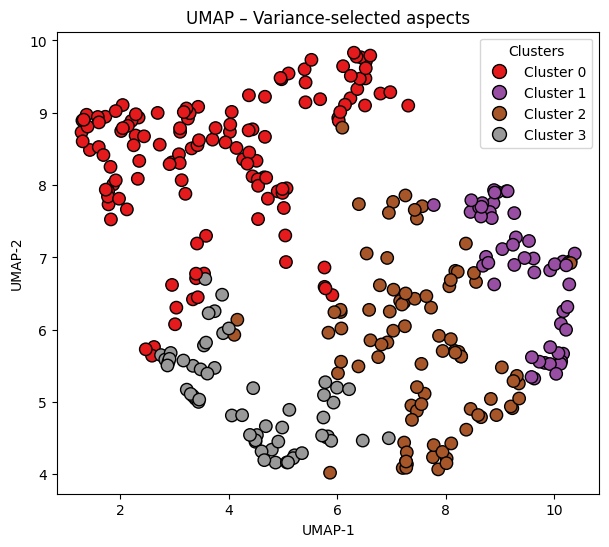

In [ ]:
# Plot variance clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

Inspecting VARIANCE clusters

In [ ]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect   growth & learning  culture  people
cluster                                    
0                     0.23     0.21    0.29
1                     0.39     0.46    0.49
2                     0.41     0.32    0.34
3                     0.42     0.19    0.23


- Winners:
    - Best "people" --> cluster 1
    - Best "growth & learning" --> cluster 3
    - Best "work-life balance" --> cluster 0
- Loser:
    - Cluster 2

In [ ]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0    128
1     52
2     88
3     57
Name: count, dtype: int64 

🟢 Cluster 0 • 128 firms
AFH Wealth Management, Active Care Group, Adecco, Age UK The National Charity, Angard Staffing, Animal and Plant Health Agency, Arcadia, Arnold Clark, Aviva, B and M Retail …

🟢 Cluster 1 • 52 firms
Abcam, ActionCOACH, AlixPartners, Apple, Bain and Company, Barnet and Chase Farm Hospitals NHS Trust, Barnett Waddingham, Bayer, Boston Consulting Group, Brewin Dolphin …

🟢 Cluster 2 • 88 firms
AJ Bell, ASOS, AXA UK, Accenture, American Express, Anglian Water, Anglo American, Aon, AstraZeneca, BAT …

🟢 Cluster 3 • 57 firms
Accor, Achieving for Children, Amey, Babcock International Group, Balfour Beatty, Barratt Developments, CBRE, CVS Group, Career Legal, Civil Service United Kingdom …



In [ ]:
X_sel

aspect,growth & learning,culture,people
firm,,,
AFH Wealth Management,0.183432,0.213018,0.331361
AJ Bell,0.387719,0.287719,0.343860
ASOS,0.258476,0.301859,0.317536
AXA UK,0.434965,0.282517,0.367832
Abcam,0.555556,0.512195,0.468835
...,...,...,...
YOOX NET A PORTER GROUP,0.201306,0.213275,0.272035
ibis,0.367925,0.245283,0.292453
mydentist UK,0.330508,0.097458,0.173729


/var/folders/d7/grxt144d6wz6r6mqxx6jmqwm0000gn/T/ipykernel_35788/1260204782.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


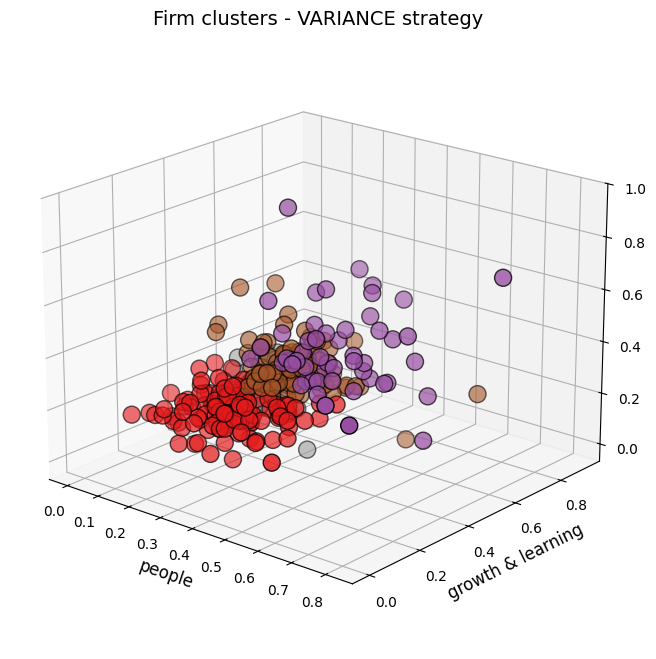

In [ ]:
# 3‑D scatter of firms on (people, growth&learning, work-life balance)

# 1) Grab the three columns in the right order
axes = ["people", "growth & learning", "culture"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k")

ax.set_xlabel("people", fontsize=12)
ax.set_ylabel("growth & learning", fontsize=12)
ax.set_zlabel("culture", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters - VARIANCE strategy", fontsize=14)
plt.show()

Clustering strategy 2: MANUAL

In [ ]:
STRATEGY = "manual"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","growth & learning"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['pay', 'work-life balance', 'growth & learning']


/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


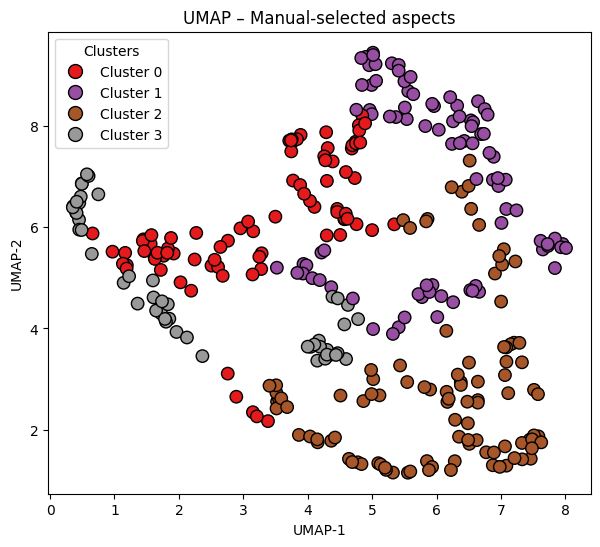

In [ ]:
# Plot MANUAL clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

Inspecting MANUAL clusters

In [ ]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect    pay  work-life balance  growth & learning
cluster                                            
0        0.26               0.42               0.38
1        0.28               0.22               0.45
2        0.21               0.24               0.25
3        0.44               0.33               0.26


- Winners:
    - Best "pay" --> cluster 0
    - Best "work-life balance" --> cluster 1
    - Best "culture" --> cluster 2
- Loser:
    - Cluster 3

In [ ]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0     83
1     90
2    102
3     50
Name: count, dtype: int64 

🟢 Cluster 0 • 83 firms
American Express, Angard Staffing, Animal and Plant Health Agency, Aon, AstraZeneca, BBC, BDO, BNP Paribas, BNY Mellon, BP …

🟢 Cluster 1 • 90 firms
AJ Bell, AXA UK, Abcam, Accenture, Accor, Achieving for Children, ActionCOACH, AlixPartners, Amey, Anglian Water …

🟢 Cluster 2 • 102 firms
AFH Wealth Management, ASOS, Age UK The National Charity, Apple, Arcadia, Aviva, B and M Retail, BHS, BPP Holdings, Babylon Health …

🟢 Cluster 3 • 50 firms
Active Care Group, Adecco, Arnold Clark, B and Q, Blue Arrow, Brook Street, CVS Group, Co op, DFS Furniture, DHL Supply Chain …



/var/folders/d7/grxt144d6wz6r6mqxx6jmqwm0000gn/T/ipykernel_35788/3065673111.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


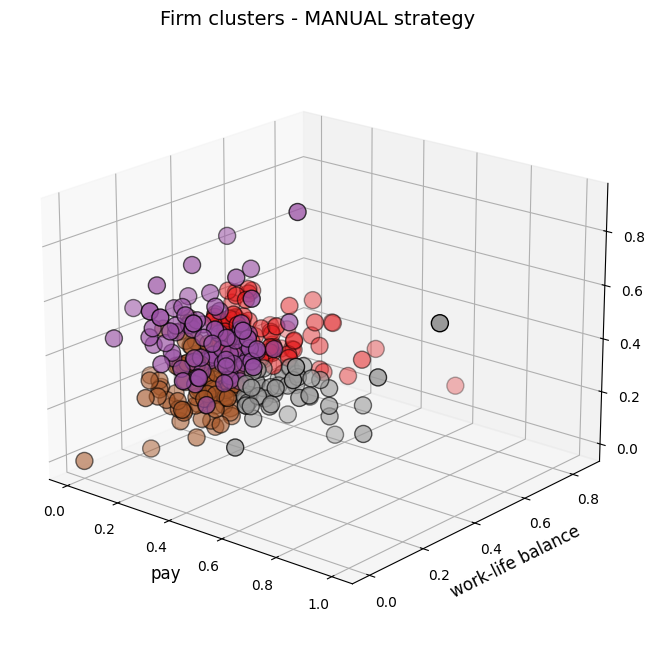

In [ ]:
# 3‑D scatter of firms on (pay, work-life balance, culture)

# 1) Grab the three columns in the right order
axes = ["pay", "work-life balance", "growth & learning"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k")

ax.set_xlabel("pay", fontsize=12)
ax.set_ylabel("work-life balance", fontsize=12)
ax.set_zlabel("growth & learning", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters - MANUAL strategy", fontsize=14)
plt.show()

Clustering strategy 3: MENTIONS

In [ ]:
STRATEGY = "mentions"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['pay', 'growth & learning', 'work-life balance']


/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mariecieslar/miniforge3/envs/nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


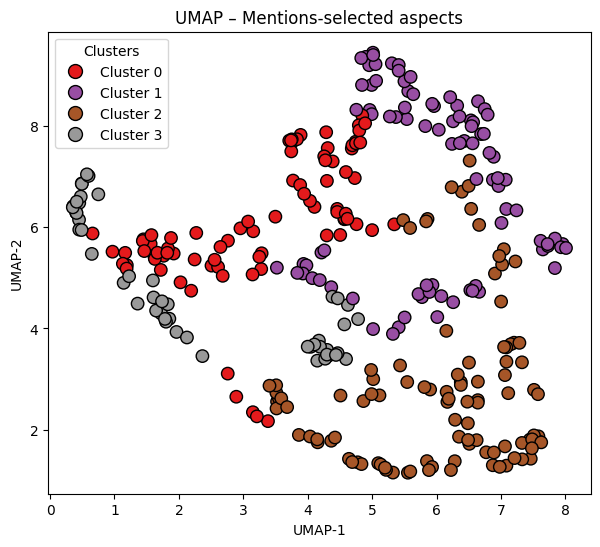

In [ ]:
# Plot mentions clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

Inspecting MENTIONS Clusters

In [ ]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect    pay  growth & learning  work-life balance
cluster                                            
0        0.26               0.38               0.42
1        0.28               0.45               0.22
2        0.21               0.25               0.24
3        0.44               0.26               0.33


- Winners:
    - Best "pay" --> cluster 2
    - Best "work-life balance" --> cluster 1
    - Best "growth & learning" --> cluster 3
- Loser:
    - Cluster 0

In [ ]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0     83
1     90
2    102
3     50
Name: count, dtype: int64 

🟢 Cluster 0 • 83 firms
American Express, Angard Staffing, Animal and Plant Health Agency, Aon, AstraZeneca, BBC, BDO, BNP Paribas, BNY Mellon, BP …

🟢 Cluster 1 • 90 firms
AJ Bell, AXA UK, Abcam, Accenture, Accor, Achieving for Children, ActionCOACH, AlixPartners, Amey, Anglian Water …

🟢 Cluster 2 • 102 firms
AFH Wealth Management, ASOS, Age UK The National Charity, Apple, Arcadia, Aviva, B and M Retail, BHS, BPP Holdings, Babylon Health …

🟢 Cluster 3 • 50 firms
Active Care Group, Adecco, Arnold Clark, B and Q, Blue Arrow, Brook Street, CVS Group, Co op, DFS Furniture, DHL Supply Chain …



## Company Selection
- To be able to keep all the 17 aspects detected by PyABSA, we decided to move forward by filtering out companies missing more than 2 of the total aspects.
- Then we imputed the missing aspect values for each company by using penalized aspect-based averages. 

In [ ]:
#build firm to set of all aspects it mentions
firm2aspects = df.groupby("firm")["aspect"].apply(set)

#get the universe of aspects
all_aspects = set(df["aspect"].unique())

#count, for each firm, how many aspects it's MISSING
missing_counts = firm2aspects.apply(lambda s: len(all_aspects - s))

#filter to those missing ≤ 2 aspects
kept_firms = missing_counts[missing_counts <= 2].index

#print how many you’d keep
print(f"Companies kept (missing ≤2 of {len(all_aspects)} aspects): {len(kept_firms)}")

Companies kept (missing ≤2 of 17 aspects): 253


There are **253 companies** with at least 15 of the 17 aspects.

In [ ]:
#filter df to only include kept firms
df_kept = df[df["firm"].isin(kept_firms)]

#total number of firms in the dataset
n_firms = df_kept["firm"].nunique()

#count how many firms mention those aspects
counts = (
    df_kept
      .groupby("aspect")["firm"]
      .nunique()
      .reset_index(name="companies_mentioning")
)

#compute missing = total firms – mentioning
counts["companies_missing"] = n_firms - counts["companies_mentioning"]

counts = counts.sort_values(
    by="companies_mentioning", ascending=False
)

counts

,aspect,companies_mentioning,companies_missing
0,culture,253,0
7,office & location,253,0
15,tools & resources,253,0
14,teamwork & collaboration,253,0
11,perks & benefits,253,0
9,people,253,0
8,pay,253,0
6,management,253,0
4,job role clarity,253,0
3,hr & recruitment,253,0


In [ ]:
print(f'Total number of aspects missing (for imputation purposes): {counts["companies_missing"].sum()}')
print(f'Average number of aspects missing per company: {round((counts["companies_missing"].sum()/n_firms),2)}')

Total number of aspects missing (for imputation purposes): 128
Average number of aspects missing per company: 0.51


There are 128 aspects missing in total, which means ~.51 missing aspects per company.

In [ ]:
#compute the average star rating per aspect
avg_aspect_scores = (
    df_kept
      .groupby("aspect")["avg_star_rating"]
      .mean()
      .reset_index(name="average_score")
      .sort_values("average_score", ascending=False)
)

avg_aspect_scores

,aspect,average_score
9,people,3.493328
11,perks & benefits,3.484277
14,teamwork & collaboration,3.431400
1,diversity & inclusion,3.384223
12,remote work,3.292259
15,tools & resources,3.255254
0,culture,3.201313
2,growth & learning,3.178803
16,work-life balance,3.080952
7,office & location,3.048829


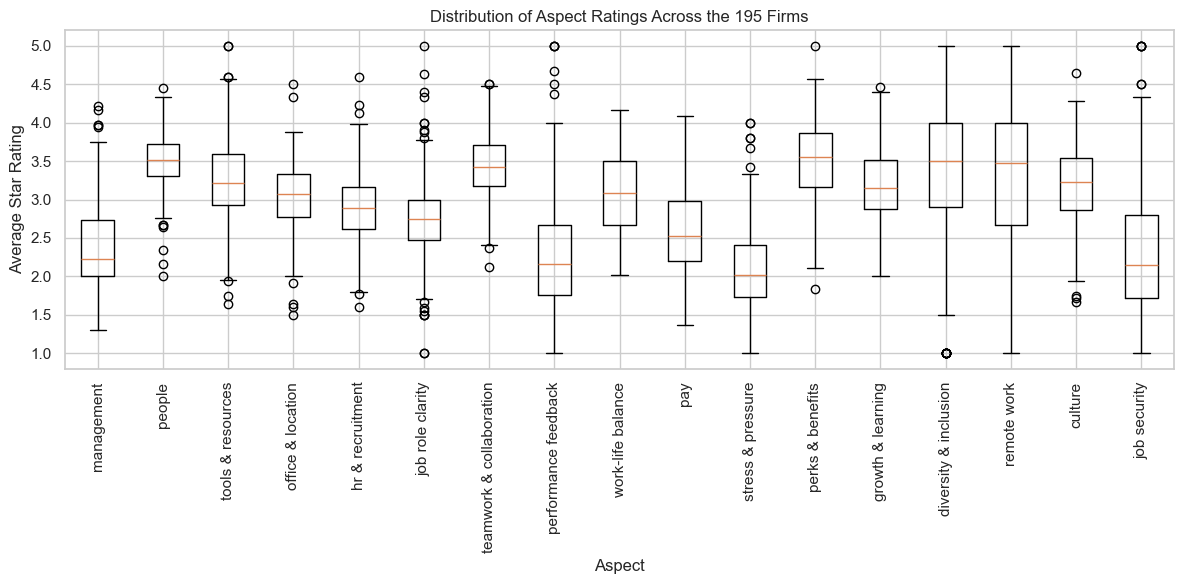

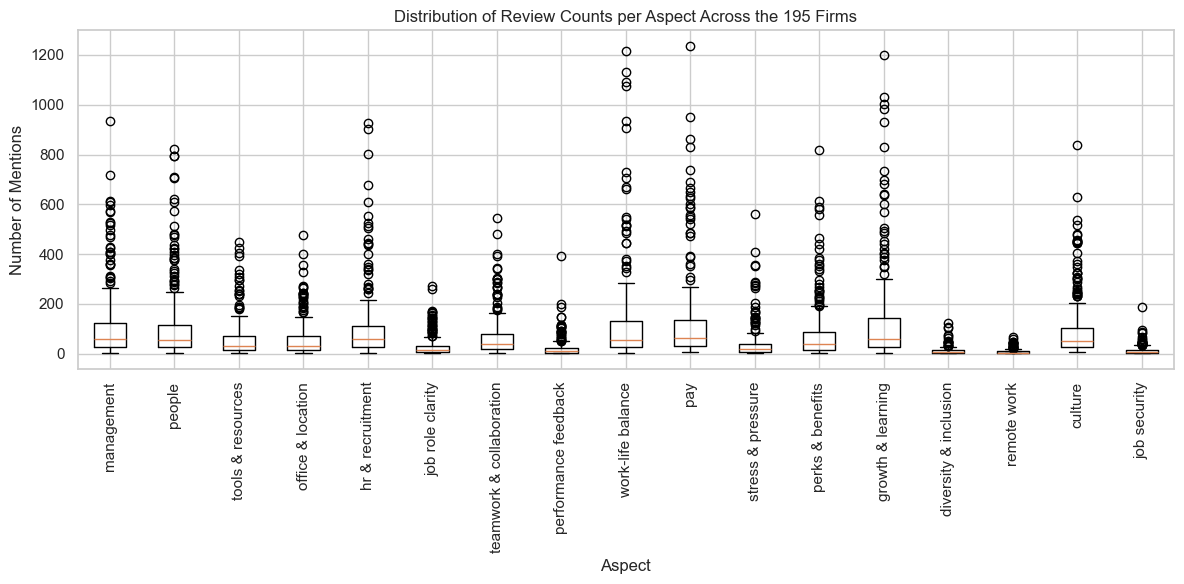

In [ ]:
#pivot into two matrices: one for ratings, one for mention counts
ratings_pivot = df_kept.pivot(index="firm", columns="aspect", values="avg_star_rating")
counts_pivot  = df_kept.pivot(index="firm", columns="aspect", values="n_mentions")

#box-plot of rating distributions
plt.figure(figsize=(12, 6))
plt.boxplot([ratings_pivot[asp].dropna() for asp in all_aspects])
plt.xticks(ticks=range(1, len(all_aspects) + 1), labels=all_aspects, rotation=90)
plt.xlabel("Aspect")
plt.ylabel("Average Star Rating")
plt.title("Distribution of Aspect Ratings Across the 195 Firms")
plt.tight_layout()
plt.show()

#box-plot of mention-count distributions
plt.figure(figsize=(12, 6))
plt.boxplot([counts_pivot[asp].dropna() for asp in all_aspects])
plt.xticks(ticks=range(1, len(all_aspects) + 1), labels=all_aspects, rotation=90)
plt.xlabel("Aspect")
plt.ylabel("Number of Mentions")
plt.title("Distribution of Review Counts per Aspect Across the 195 Firms")
plt.tight_layout()
plt.show()

C:\Users\lasko\AppData\Local\Temp\ipykernel_33212\1791559765.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


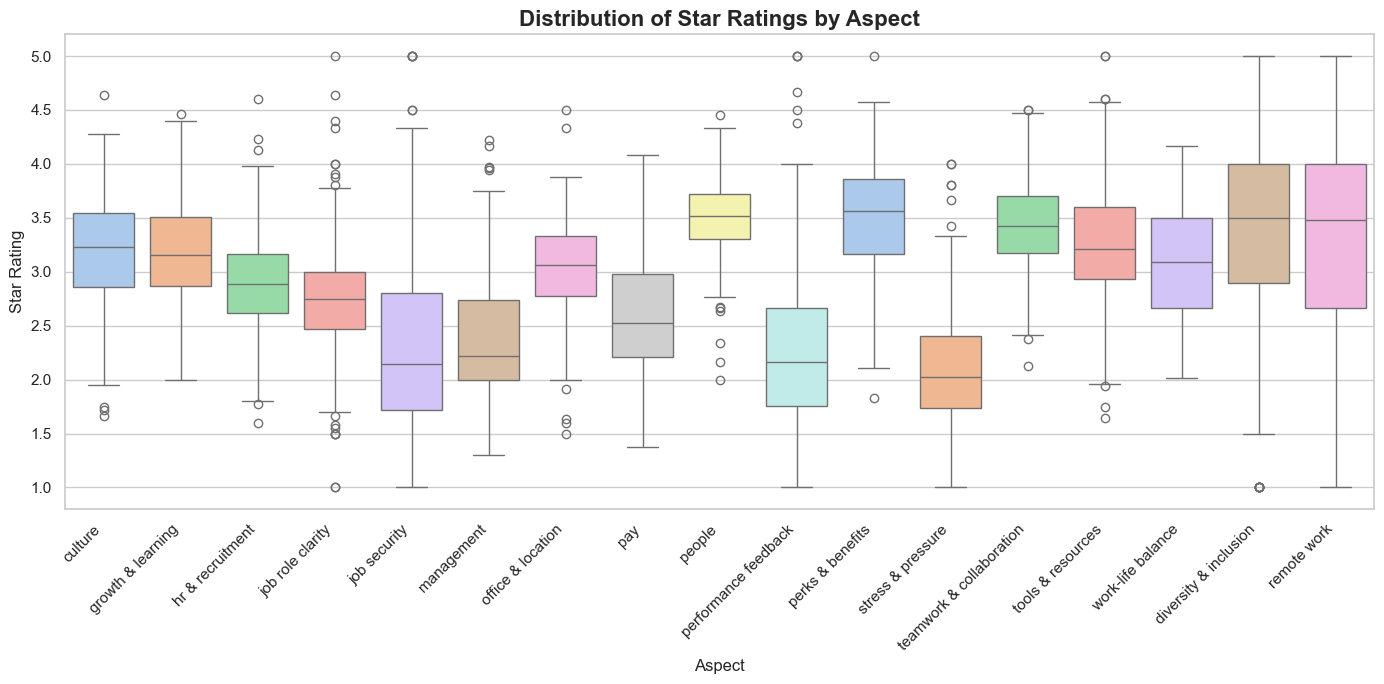

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

ax = sns.boxplot(
    data=df_kept,
    x="aspect",
    y="avg_star_rating",
    palette="pastel",
    showfliers=True
)

plt.title("Distribution of Star Ratings by Aspect", fontsize=16, fontweight='bold')
plt.xlabel("Aspect", fontsize=12)
plt.ylabel("Star Rating", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**INSIGHTS:**
- **Top-Rated Aspects (Higher Medians)**
  - People
  - Teamwork & Collaboration
  - Perks & Benefits
  - Remote Work
  - Work-Life Balance

- **Lowest-Rated Aspects**
  - Stress & Pressure
  - Job Security and Performance Feedback
  - Pay

- **Aspects with High Variability**
  - Job Security
  - Performance Feedback
  - Diversity & Inclusion
  - Pay 
  - Job Role Clarity
  - Management



- **Most Frequently Mentioned Aspects**
  - Growth & Learning
  - Pay
  - Perks & Benefits
  - Work-Life Balance

- **Least Frequently Mentioned Aspects**
  - Job Security
  - Performance Feedback
  - Diversity & Inclusion
  - Remote Work

- **Aspects with High Variability in Mentions**
  - Management
  - People
  - Pay
  - Work-Life Balance

In [ ]:
total_reviews = df_kept.groupby("firm")["n_mentions"].sum()

#from kept firms, pick the ones missing remote work:
kept_missing_remotework = [
    f for f in kept_firms
    if "remote work" not in firm2aspects[f]
]

#build the summary for just those:
summary = pd.DataFrame({
    "firm":           kept_missing_remotework,
    "missing_count":  [missing_counts[f] for f in kept_missing_remotework],
    "total_reviews":  [total_reviews[f]   for f in kept_missing_remotework]
})

print(f"Found {len(summary)} kept firms missing ‘remote work’\n")
summary.sort_values("total_reviews", ascending=False)

Found 69 kept firms missing ‘remote work’



,firm,missing_count,total_reviews
67,XPO Logistics,1,1707
6,Arcadia,1,1534
23,David Lloyd Leisure,1,1049
9,Balfour Beatty,1,967
35,Kurt Geiger,1,928
...,...,...,...
55,Square Enix,2,97
18,Colosseum Dental,1,92
60,The Coal Authority,1,84
50,Rural Payments Agency,2,66


In [ ]:
#from kept firms, pick the ones missing diversity and inclusion:
kept_missing_di = [
    f for f in kept_firms
    if "diversity & inclusion" not in firm2aspects[f]
]

#build the summary for just those:
summary = pd.DataFrame({
    "firm":           kept_missing_di,
    "missing_count":  [missing_counts[f] for f in kept_missing_di],
    "total_reviews":  [total_reviews[f]   for f in kept_missing_di]
})

print(f"Found {len(summary)} kept firms missing ‘diversity & inclusion’\n")
summary.sort_values("total_reviews", ascending=False)

Found 35 kept firms missing ‘diversity & inclusion’



,firm,missing_count,total_reviews
5,Barchester Healthcare,2,795
17,HC One,1,728
4,Bannatyne Group,2,720
21,Mountain Warehouse,1,630
15,Four Seasons Health Care,2,510
2,Arnold Clark,2,452
3,BHS,2,450
12,Diligenta,1,443
14,Everyone Active,1,427
23,NHS Professionals,1,410


We would like to analyze if number of aspects that companies miss is correlated with the number of reviews:

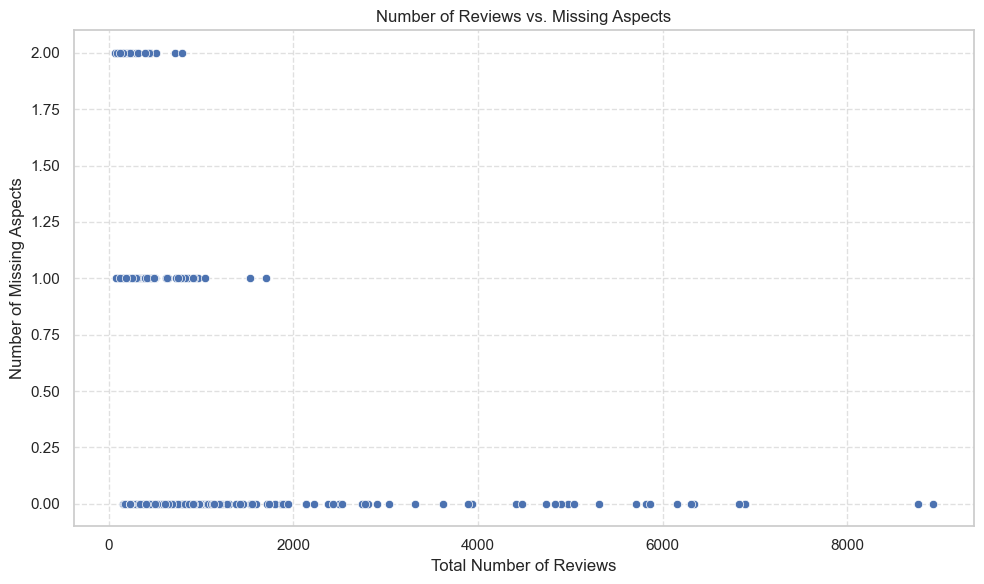

In [ ]:
#restrict both series to the good firms (with ≤ 2 missing aspects)
kept_missing_counts = missing_counts.loc[kept_firms]
kept_total_reviews = df_kept.groupby("firm")["n_mentions"].sum()

#create a DataFrame for plotting
scatter_df = pd.DataFrame({
    "firm": kept_firms,
    "missing_aspects": kept_missing_counts.values,
    "total_reviews": kept_total_reviews.values
})

# 3) Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_df, x="total_reviews", y="missing_aspects")
plt.title("Number of Reviews vs. Missing Aspects")
plt.xlabel("Total Number of Reviews")
plt.ylabel("Number of Missing Aspects")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
#group review counts by number of missing aspects (0, 1, 2)
group0 = scatter_df[scatter_df["missing_aspects"] == 0]["total_reviews"]
group1 = scatter_df[scatter_df["missing_aspects"] == 1]["total_reviews"]
group2 = scatter_df[scatter_df["missing_aspects"] == 2]["total_reviews"]

#run one-way ANOVA
f_stat, p_val = f_oneway(group0, group1, group2)

#print results with interpretation
print("ANOVA Test: Do firms with different numbers of missing aspects differ in their average number of reviews?\n")
print(f"Means: 0→{group0.mean():.2f}, 1→{group1.mean():.2f}, 2→{group2.mean():.2f}")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4g}")

ANOVA Test: Do firms with different numbers of missing aspects differ in their average number of reviews?

Means: 0→1678.54, 1→449.07, 2→257.43
F-statistic: 23.7179
P-value: 3.701e-10


There is strong evidence that **firms with more missing aspects have significantly fewer reviews**.

#### Missing Aspect Value Imputation

In [ ]:
# pivot out the matrix (no imputation yet)
base_mat = (
    df_kept
    .pivot(index="firm", columns="aspect", values="avg_star_rating")
)
base_mat = base_mat.reindex(index=kept_firms, columns=all_aspects)

In [ ]:
base_mat

aspect,management,people,tools & resources,office & location,hr & recruitment,job role clarity,teamwork & collaboration,performance feedback,work-life balance,pay,stress & pressure,perks & benefits,growth & learning,diversity & inclusion,remote work,culture,job security
firm,,,,,,,,,,,,,,,,,
AFH Wealth Management,2.375000,3.294118,2.111111,3.142857,2.521739,1.000000,2.571429,2.500000,3.166667,1.894737,2.000000,3.000000,3.444444,NaN,NaN,2.769231,1.400000
AJ Bell,2.804878,3.438596,3.413793,3.468085,3.000000,2.125000,3.290323,2.875000,2.870968,2.428571,2.928571,2.862745,3.250000,3.000000,4.333333,3.416667,2.800000
ASOS,1.754464,3.311787,2.864407,3.285714,2.807692,2.350877,2.701987,1.809524,2.644444,2.335000,2.404040,3.685237,2.550360,2.944444,3.000000,3.209302,1.400000
AXA UK,2.781250,3.704225,3.454545,3.057143,3.192982,3.100000,3.702703,2.333333,3.730769,3.029851,1.800000,3.953125,3.534091,4.250000,3.125000,3.543860,2.500000
Abcam,3.530612,4.119048,3.833333,3.302632,3.513514,3.266667,4.105263,3.400000,4.063830,2.418605,3.119048,3.725000,3.474576,4.250000,4.750000,4.153846,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XPO Logistics,3.140940,3.918519,4.229508,3.068966,3.828571,3.541667,4.050955,3.312500,2.959350,3.048485,3.132353,3.352941,4.049383,4.214286,NaN,3.810127,3.651163
XPS Pensions Group,3.200000,4.333333,3.666667,3.090909,3.333333,4.000000,4.222222,1.750000,2.454545,2.000000,2.000000,3.125000,3.684211,NaN,NaN,4.000000,2.500000
YOOX NET A PORTER GROUP,1.634146,3.048780,2.693878,3.275000,2.775000,1.700000,2.846154,1.615385,2.821429,1.871429,2.041667,3.530435,2.151163,3.333333,3.800000,2.450000,1.333333


In [ ]:
#count missing per column
missing_per_col = base_mat.isna().sum()

#check the number of total missing values
total_missing = missing_per_col.sum()
print(f"\nTotal missing values in matrix: {total_missing}")


Total missing values in matrix: 128


Imputation using the mean of each aspect rating and penalty = 0.8:

$0.8 \times \text{mean\_aspect\_rating}$

In [ ]:
#compute 80% of each aspect’s observed mean
aspect_means = base_mat.mean()
fill_values  = aspect_means * 0.8

#impute: NaN → 0.8 × mean
imputed_mat = base_mat.fillna(fill_values)

print(imputed_mat.shape)
imputed_mat.head()

(253, 17)


aspect,management,people,tools & resources,office & location,hr & recruitment,job role clarity,teamwork & collaboration,performance feedback,work-life balance,pay,stress & pressure,perks & benefits,growth & learning,diversity & inclusion,remote work,culture,job security
firm,,,,,,,,,,,,,,,,,
AFH Wealth Management,2.375000,3.294118,2.111111,3.142857,2.521739,1.000000,2.571429,2.500000,3.166667,1.894737,2.000000,3.000000,3.444444,2.707378,2.633808,2.769231,1.4
AJ Bell,2.804878,3.438596,3.413793,3.468085,3.000000,2.125000,3.290323,2.875000,2.870968,2.428571,2.928571,2.862745,3.250000,3.000000,4.333333,3.416667,2.8
ASOS,1.754464,3.311787,2.864407,3.285714,2.807692,2.350877,2.701987,1.809524,2.644444,2.335000,2.404040,3.685237,2.550360,2.944444,3.000000,3.209302,1.4
AXA UK,2.781250,3.704225,3.454545,3.057143,3.192982,3.100000,3.702703,2.333333,3.730769,3.029851,1.800000,3.953125,3.534091,4.250000,3.125000,3.543860,2.5
Abcam,3.530612,4.119048,3.833333,3.302632,3.513514,3.266667,4.105263,3.400000,4.063830,2.418605,3.119048,3.725000,3.474576,4.250000,4.750000,4.153846,2.5


In [ ]:
#count missing per column
missing_per_col = imputed_mat.isna().sum()

#confirm that there are zero missing overall
total_missing = missing_per_col.sum()
print(f"\nTotal missing values in matrix: {total_missing}")


Total missing values in matrix: 0


In [ ]:
aspect_cols = [c for c in imputed_mat.columns]

#melt ratings wide→long
ratings_long = (
    imputed_mat
    .reset_index()
    .melt(id_vars="firm", value_vars=aspect_cols,
          var_name="aspect", value_name="avg_star_rating")
)

#melt counts wide→long
counts_long = (
    counts_pivot
    .reset_index()
    .melt(id_vars="firm", value_vars=aspect_cols,
          var_name="aspect", value_name="n_mentions")
)

#merge and fill imputed counts with 0
long_df = (
    ratings_long
    .merge(counts_long, on=["firm","aspect"], how="left")
)
long_df["n_mentions"] = long_df["n_mentions"].fillna(0).astype(int)

#sort or re‐order
long_df = long_df.sort_values(["firm","aspect"]).reset_index(drop=True)

long_df.head()


,firm,aspect,avg_star_rating,n_mentions
0,AFH Wealth Management,culture,2.769231,13
1,AFH Wealth Management,diversity & inclusion,2.707378,0
2,AFH Wealth Management,growth & learning,3.444444,9
3,AFH Wealth Management,hr & recruitment,2.521739,23
4,AFH Wealth Management,job role clarity,1.000000,4


In [ ]:
#save to CSV
long_df.to_csv(
    "Final_imputed_company_aspect_matrix_with_counts.csv", index=False
)

### Filtering out companies with less than 20 reviews
- To be able to make more accurate suggestions to users

In [ ]:
#load both files
filtered_df = pd.read_csv("filtered_england_recent.csv")

#count number of reviews per company in the filtered file
review_counts = filtered_df['firm'].value_counts()

#get firms with at least 20 reviews
valid_firms = review_counts[review_counts >= 20].index

#filter the matrix file to only include these firms
filtered_matrix_df = long_df[long_df['firm'].isin(valid_firms)]

kept_firms_after_filtering = filtered_matrix_df['firm'].unique()
kept_firms_after_filtering = pd.Index(kept_firms_after_filtering)

filtered_matrix_df.head()

,firm,aspect,avg_star_rating,n_mentions
0,AFH Wealth Management,culture,2.769231,13
1,AFH Wealth Management,diversity & inclusion,2.707378,0
2,AFH Wealth Management,growth & learning,3.444444,9
3,AFH Wealth Management,hr & recruitment,2.521739,23
4,AFH Wealth Management,job role clarity,1.000000,4


In [ ]:
len(filtered_matrix_df.groupby('firm'))

249

In [ ]:
#save to CSV
filtered_matrix_df.to_csv(
    "Final_filtered_imputed_company_aspect_matrix_with_counts.csv", index=False
)

## Filtering out companies from the dataset with summarizations by company

In [ ]:
df_summary = pd.read_csv("company_merged_summaries_updated.csv")

In [ ]:
df_summary_filtered = df_summary[df_summary['firm'].isin(kept_firms_after_filtering)]
len(df_summary_filtered), len(kept_firms_after_filtering)

(249, 249)

We are missing 2 company summaries:

In [ ]:
missing_in_summary = kept_firms_after_filtering.difference(df_summary['firm'])
print(missing_in_summary)

Index([], dtype='object')


Creating the final dataset with all summarizations:

In [ ]:
df_summary_filtered.to_csv('firms_filtered_summarized.csv', index=False)